In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

np.random.seed(1) # random seed for reproducibiltiy

Using Theano backend.


# Explore IMDB dataset

In [3]:
from matplotlib import pyplot
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [4]:
## SUMMAIZATION
print(X.shape)
print(y.shape)
print(np.unique(y))
print(len(np.unique(np.hstack(X))))
result = map(len, X)
print(np.mean(result), np.std(result))

(50000L,)
(50000L,)
[0 1]
88585
(234.75891999999999, 172.91149458735703)


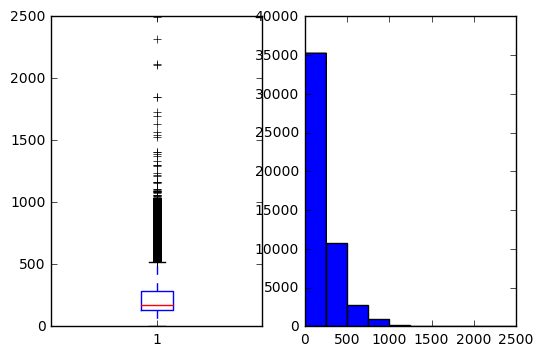

In [5]:
## PLOT
pyplot.subplot(121)
pyplot.boxplot(result)
pyplot.subplot(122)
pyplot.hist(result)
pyplot.show()

# Data Load

In [ ]:
## LOAD DATASET with top-words
top_words = 5000 # 5000번째 freq 단어들만 로드하겠다 (vocabulary size=5000)
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

## ZERO PADDING
max_words = 500 # 하나의 문서는 500개의 단어들까지만 구성하겠다 그 이상은 짜르고 그 이하는 zero-패딩하겠다
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [30]:
len(X_train)

25000

In [39]:
# 하나의 example을 살펴보자
# 0이 있는 이유는 500길이로 zero-padding했기 때문이다.
# 번호는 vocabulary의 index이다. 위에서 top_words=5000이기 때문에 우리의 voca size는 5000이다
X_train[200]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

단어 하나하나마다 voca size인 5000 dim이 주어지는게 아니고 그냥 numerical value로 사용된다.

In [38]:
y_train[200]

1

# FNN

In [7]:
# embedding layer 내부적으로 index numerical value를 voca size만큼의 one-hot encoding을 해주고 난 다음 word embedding을 해준다
# Embedding()은 내부적으로 one-hot encoding 과정이 포함되어있다

## DESIGN MODEL
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words)) # 32 x 500
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 16000)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 250)           4000250     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             251         dense_1[0][0]                    
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_______________

In [8]:
# TRAIN MODEL
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
24s - loss: 0.5366 - acc: 0.6864 - val_loss: 0.2966 - val_acc: 0.8758
Epoch 2/2
25s - loss: 0.2048 - acc: 0.9208 - val_loss: 0.2982 - val_acc: 0.8764
Accuracy: 87.64%


# CNN

CNN은 image에서 position and orientation과 같은 spatial structure 패턴을 찾는데 강함. <br>
이것을 똑같이 sequence에도 적용가능함. 이들의 성질인 invariance to the specific position of features를 사용해 image에서 object를 찾는 것과 같이 paragraph에서 word를 찾을 수 있음. 

In [13]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

## DESIGN MODEL
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Conv1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 500, 32)       160000      embedding_input_6[0][0]          
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 500, 32)       3104        embedding_6[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_2[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 8000)          0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

1D Convolution이기 때문에 Convolution layer를 거쳤음에도 불구하고 data shape는 embedding layer와 같이 500 x 32로 바뀌지 않았다. Pooling layer에서 압축을 한다.

In [15]:
# TRAIN MODEL
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
62s - loss: 0.4378 - acc: 0.7702 - val_loss: 0.2818 - val_acc: 0.8822
Epoch 2/2
64s - loss: 0.2284 - acc: 0.9082 - val_loss: 0.2747 - val_acc: 0.8832
Accuracy: 88.32%


# LSTM

Sequence classification 문제의 어려운 점
* sequence들의 길이다 모두 상이하다
* large vocabulary size를 가진다
* long term context or dependencies를 요구한다

In [17]:
from keras.layers import LSTM

## DESIGN MODEL
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_7 (Embedding)          (None, 500, 32)       160000      embedding_input_7[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 100)           53200       embedding_7[0][0]                
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 1)             101         lstm_1[0][0]                     
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
____________________________________________________________________________________________________
None


In [ ]:
# TRAIN MODEL
model.fit(X_train, y_train, nb_epoch=2, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

# LSTM with dropout

Recurrent neural networks like LSTM generally have the problem of overfitting.

### (1) Layer-wise dropout

In [26]:
from keras.layers import Dropout

## DESIGN MODEL
embedding_vecor_length = 32 
model = Sequential() 
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_words, dropout=0.2)) 
model.add(Dropout(0.2)) 
model.add(LSTM(100)) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary()) 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_10 (Embedding)         (None, 500, 32)       160000      embedding_input_10[0][0]         
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 500, 32)       0           embedding_10[0][0]               
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 100)           53200       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           lstm_3[0][0]                     
___________________________________________________________________________________________

In [ ]:
# Final evaluation of the model 
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

dropout을 적용하면 상대적으로 converge가 느리게 되는데 이전보다 epoch를 좀 더 늘릴 필요가 있다

### (2) LSTM specific dropout
Dropout is applied to input and recurrent connections of the memory units with the LSTM

* *dropout_W*: for configuring the input dropout
* *dropout_U*: for configuring the recurrent dropout


In [27]:
## DESIGN MODEL
embedding_vecor_length = 32 
model = Sequential() 
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_words, dropout=0.2)) 
model.add(LSTM(100, dropout_W=0.2, dropout_U=0.2)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_11 (Embedding)         (None, 500, 32)       160000      embedding_input_11[0][0]         
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 100)           53200       embedding_11[0][0]               
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 1)             101         lstm_4[0][0]                     
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
____________________________________________________________________________________________________
None


dropout을 하는 방법은 (1), (2)으로 2가지 종류가 있는데, 모두 결과가 (당연히) 다르게 나온다. 똑같은 epoch으로 실험했을 때 (2)의 경우가 accuracy가 더 낮게 나온다 이는 (2)번이 dropout을 더 많이 주는 효과?가 있다고 볼 수 있다 (또는 overfitting을 더 잘 해결할 수도 있다고 해석할 수 있다)

즉, LSTM specific dropout이 layer-wise dropout보다 좀 더 좋은 성능을 낼 수도 있다

# LSTM and CNN

CNN은 spatial structure를 잘 추출하는데, 2D가 아닌 1D Convolution을 이용하면 image뿐만 아니라 text의 spatial structure도 잘 추출할 수 있다. (text에서 spatial structure는 paragraph에서 특정 word들이라고 말할 수 있다)

CNN may be able to pick out invariant features for good and bad sentiment from IMDB. <br>
This learned spatial features may then be learned as sequences by an LSTM layer.

In [23]:
## DESIGN MODEL
embedding_vecor_length = 32 
model = Sequential() 
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_words)) 
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu')) 
model.add(MaxPooling1D(pool_length=2)) 
model.add(LSTM(100)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary()) 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_8 (Embedding)          (None, 500, 32)       160000      embedding_input_8[0][0]          
____________________________________________________________________________________________________
convolution1d_3 (Convolution1D)  (None, 500, 32)       3104        embedding_8[0][0]                
____________________________________________________________________________________________________
maxpooling1d_2 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_3[0][0]            
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 100)           53200       maxpooling1d_2[0][0]             
___________________________________________________________________________________________

In [ ]:
model.fit(X_train, y_train, nb_epoch=3, batch_size=64) 
# Final evaluation of the model 
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Embedding 다음에 곧바로 CNN Layer를 넣어줘서 학습시간은 좀 더 빠르게 할 수 있다 (simple LSTM모델 보다는 학습 시간이 좀 더 빠르다)